# Example 1 (from README)

In [1]:
from src.urls import crawlPrivacy, filterPrivacy
status, urls = crawlPrivacy('www.aa.com',clicks=2) # crawl to find candidate URLs
ranked = filterPrivacy(sum(urls,[])) # filter and rank by likelihood of being a privacy policy
from src.text import findPolicy
status, policy, url = findPolicy(ranked) # scrape highest ranked page that contains 'privacy'

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


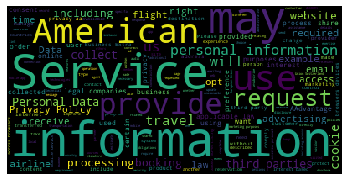

In [2]:
# word cloud
%matplotlib inline
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wc = WordCloud()
wc.generate(' '.join(policy))
plt.imshow(wc); plt.axis('off')
plt.savefig('aa_wc.png')

In [3]:
# attributes
from src.attributes import isVisible, fogIndex, policyLength
status, visible = isVisible('www.aa.com')
fog = fogIndex(' '.join(policy))
pars, words = policyLength(policy)

# output
print('\n')
# is 'privacy' visible on main website?
if status and visible:
    print('Privacy is visible on main website')
elif status and not visible:
    print('Privacy is not visible on main website')
else:
    print('Could not get HTML data for visibility')
# gunning fog index
print('Fog index is %.2f' % fog)
# length
print('Policy contains %d paragraphs and %d words' % (pars,words))

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


TEXT IS NOT BEING PRE PROCESSED
type(text) == <class 'str'> ; Size Text: 34883


Privacy is visible on main website
Fog index is 20.63
Policy contains 103 paragraphs and 5472 words


# Example 2: Legal clarity
Our legal clarity index is an ordinal measure, defined relative to a corpus of policies (this is because it is based on the relative TF.IDF frequency of certain terms in each document)

In this example, we crawl two websites to make a mini corpus and calculate the legal clarity of their policies.

*Warning*: For these two websites, our scraping method works fine, so that `status==True` for both. When applying this to wide lists of websites, the code needs to be modified to handle errors.

In [4]:
from src.urls import crawlPrivacy, filterPrivacy
from src.text import findPolicy
from src.attributes import legalClarity

sites = ['www.aa.com','www.ba.com']

# loop to find URLs
status, urls = {} , {}
for dom in sites:
    status[dom], urls[dom] = crawlPrivacy(dom,clicks=2) 
    
# loop to get policies
policies = {}
for dom in sites:
    ranked = filterPrivacy(sum(urls[dom],[])) 
    _, policies[dom], _ = findPolicy(ranked)
    
# legal clarity index
lc = legalClarity(policies)
for dom in sites:
    print('Legal clarity of %s: %.3f' % (dom,lc[dom]))

Legal clarity of www.aa.com: 1.136
Legal clarity of www.ba.com: 1.691


# Detail: URLs module
This module contains functions that find candidate URLs to privacy policies on a website

In [5]:
# crawl website (this takes a while for clicks > 1)
from src.urls import crawlPrivacy
status, urls = crawlPrivacy('www.aa.com',clicks=2)

# result is a list of lists of URLs, ordered by number of clicks 
# e.g., the first list urls[0] contains the links accessible with one click
for i,x in enumerate(urls):
    print('Crawler finds %d URLs with %d click(s)' % (len(x),i+1))

Crawler finds 64 URLs with 1 click(s)
Crawler finds 341 URLs with 2 click(s)


In [6]:
# filter and rank the URLs 
from src.urls import filterPrivacy
ranked = filterPrivacy(sum(urls,[]))

# result is a list of URLs ranked from high to low likelihood of being a privacy policy
# URLs that contain none of a list of relevant keywords are thrown out
# see /src/urls.py for definition of this filter
print('Top 5 candidate URLs from crawler:\n' + '\n'.join(ranked[0:5]))

Top 5 candidate URLs from crawler:
http://www.aa.com/i18n/customer-service/support/privacy-policy.jsp
http://www.aa.com//i18n/customer-service/support/privacy-policy.jsp
http://www.aa.com/i18n/customer-service/support/legal-privacy-copyright.jsp?locale=en_GB
http://www.aa.com/travelInformation/flights/schedule?locale=en_GB&anchorEvent=false&from=Nav
http://www.aa.com/travelInformation/flights/schedule


In [7]:
# alternative method: perform site-specific serch for 'privacy' with Google Custom Search
from src.urls import googlePrivacy

# credentials needed!
my_api_key = ""
my_cse_id = ""

# arguments: num = number of results, gl = location, lr = language
status, result = googlePrivacy('www.aa.com', my_api_key, my_cse_id, num=5, gl = 'us', lr = 'lang_en')

# result is a list of seach result URLs 
print('Links found on Google:\n' + '\n'.join(result))

Links found on Google:
https://www.aa.com/i18n/customer-service/support/privacy-policy.jsp
https://www.aa.com/i18n/customer-service/support/legal-privacy-copyright.jsp
https://my.aa.com/privacy-policy/
https://jobs.aa.com/
https://my.aa.com/wp-content/uploads/2017/08/2017-HIPAA-Complaint-Form.pdf


# Detail: Text module
This module contains functions to download privacy policies (given candidate URLs) and cleans them

In [8]:
from src.text import findPolicy, cleanPolicy

In [9]:
# from a ranked list of URLs, scrape first webpage that contains 'privacy'
status, policy, url = findPolicy(ranked)

# result is a list of paragraphs and the URL where they were found
if status: 
    print('Policy found at %s, with %d paragraphs \n' % (url,len(policy)))
    print('First 3 paragraphs:\n\n' + '\n\n'.join(policy[0:3]))

Policy found at http://www.aa.com/i18n/customer-service/support/privacy-policy.jsp, with 103 paragraphs 

First 3 paragraphs:

This Privacy Policy explains how American Airlines, Inc. ("we," "us," "our," "American") collects, uses, shares, and protects information in connection with American’s services, systems, websites, and apps that refer or link to this Privacy Policy (our "Services"), including without limitation, the collection and processing of personal information in connection with bookings and travel on American Airlines or flights operated by our regional carriers (for example, Envoy Air, Piedmont Airlines and PSA Airlines). This Privacy Policy applies regardless of the type of device or other means you use to access our Services.

American reserves the right to change this Privacy Policy at any time by posting the updated Policy here along with the date on which the Policy was changed. If we make material changes to this Privacy Policy that affect the way we collect, use an

In [10]:
# clean up text for natural language processing
tokens, lemmas = cleanPolicy(policy)

# results is a list of lists of lemmas (one list for each paragraph)
print('Lemmas in first 3 paragraphs:\n')
print('\n\n'.join([','.join(l) for l in lemmas[0:3]]))

Lemmas in first 3 paragraphs:

privacy,policy,explains,american,airline,inc,u,collect,us,share,protects,information,connection,service,system,website,apps,refer,link,including,without,limitation,collection,processing,personal,booking,travel,flight,operated,regional,carrier,example,envoy,air,piedmont,psa,applies,regardless,type,device,mean,use,access

american,reserve,right,change,privacy,policy,time,posting,updated,along,date,changed,make,material,affect,way,collect,use,andor,share,personal,information,notify,including,newly,label,link,aacom,day,made

collect,maintain,personal,information,many,source,understand,meet,need,facilitate,travel,manage,business,purpose,disclosed,example
